# Text Classification - OneClass Classificaiton

The one-class algorithms are based on recognition since their aim is to recognize data from a particular class, and reject data from all other classes. This is accomplished by creating a boundary that encompasses all the data belonging to the target class within itself, so when a new sample arrives the algorithm only has to check whether it lies within the boundary or outside and accordingly classify the sample as belonging to the target class or the outlier.

Things we are going to discuss:

1. Data Preparation 
2. Cleaning and Tokenization
3. Feature Extraction
4. Train One-class classificaiton model
5. Predict one-class on test data

In [1]:
# Load packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.utils import shuffle
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import string
import spacy
import nltk
from spacy.lang.en import English
#nltk_tokens = nltk.sent_tokenize(sentence_data)
#spacy.load('en')
#parser = English()

In [2]:
# load dataset
bbc_df = pd.read_csv(r'C:\Users\ranjith_n\Downloads\prod_tasklist.csv',encoding='latin1')

In [3]:
bbc_df.head(10)

,PROJ_NAME,TRACK GROUP,TRACK,DOMAIN,TASK,category,Unnamed: 6,Unnamed: 7
0,Alkermes,WINTEL DOMAIN,Vmware,Powershell,VM tools updates by ESX update,automatable,NaN,NaN
1,Alkermes,WINTEL DOMAIN,Vmware,Powershell,Patch Management,automatable,NaN,NaN
2,Alkermes,WINTEL DOMAIN,Vmware,Powershell,VM Deployment with command,automatable,NaN,NaN
3,Alkermes,WINTEL DOMAIN,Vmware,"Tools, Optibot, Python & Misc",Performance report,automatable,NaN,NaN
4,Alkermes,WINTEL DOMAIN,Vmware,Powershell,"Report for snapshot, CDP and etc",automatable,NaN,NaN
5,Alkermes,WINTEL DOMAIN,Vmware,Powershell,VM Hardware installation with commands,automatable,NaN,NaN
6,Alkermes,WINTEL DOMAIN,Vmware,Powershell,VM Startup and Shutdown with commands,automatable,NaN,NaN
7,Alkermes,NETWORKS DOMAIN,Network,Powershell,Device Up/Down,automatable,NaN,NaN
8,Alkermes,NETWORKS DOMAIN,Network,Powershell,Link/Interface Up Down,automatable,NaN,NaN
9,Alkermes,NETWORKS DOMAIN,Network,Powershell,CPU Utilization,automatable,NaN,NaN


In [4]:
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16971 entries, 0 to 16970
Data columns (total 8 columns):
PROJ_NAME      14416 non-null object
TRACK GROUP    14416 non-null object
TRACK          14416 non-null object
DOMAIN         14416 non-null object
TASK           16971 non-null object
category       16971 non-null object
Unnamed: 6     3 non-null object
Unnamed: 7     1 non-null object
dtypes: object(8)
memory usage: 1.0+ MB


In [5]:
#bbc_df['category'] = 1
bbc_df['category'].unique()

array(['automatable', 'non-automatable'], dtype=object)

In [6]:
bbc_df['category'].value_counts()

automatable        14416
non-automatable     2555
Name: category, dtype: int64

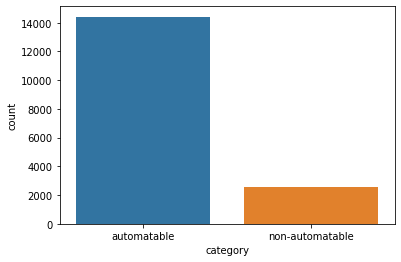

In [7]:
sns.countplot(bbc_df['category'])

# wordcloud for ALL inputs

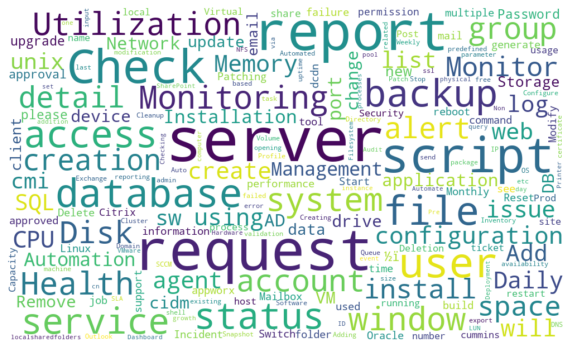

In [8]:
%matplotlib inline

from wordcloud import WordCloud

all_words = ' '.join([text for text in bbc_df.TASK])

wordcloud = WordCloud(width= 1000, height= 600,
                          max_font_size = 110,
                          collocations = False,background_color='white').generate(all_words)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word cloud for automatable tasks

In [13]:
autoip = bbc_df[bbc_df['category'] == 1]['TASK']
noautoip = bbc_df[bbc_df['category'] == -1]['TASK']
print(len(autoip))
print(len(noautoip))

0
0


In [10]:
%matplotlib inline

from wordcloud import WordCloud

all_words = ' '.join([text for text in autoip])

realwordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color='white').generate(all_words)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(realwordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

# word cloud for non-automatable inputs

In [12]:
%matplotlib inline

from wordcloud import WordCloud

all_words = ' '.join([text for text in noautoip])

fakewordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color='white').generate(all_words)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(fakewordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#as we can see man,new,report,woman,american,trump are the most used words

ValueError: We need at least 1 word to plot a word cloud, got 0.

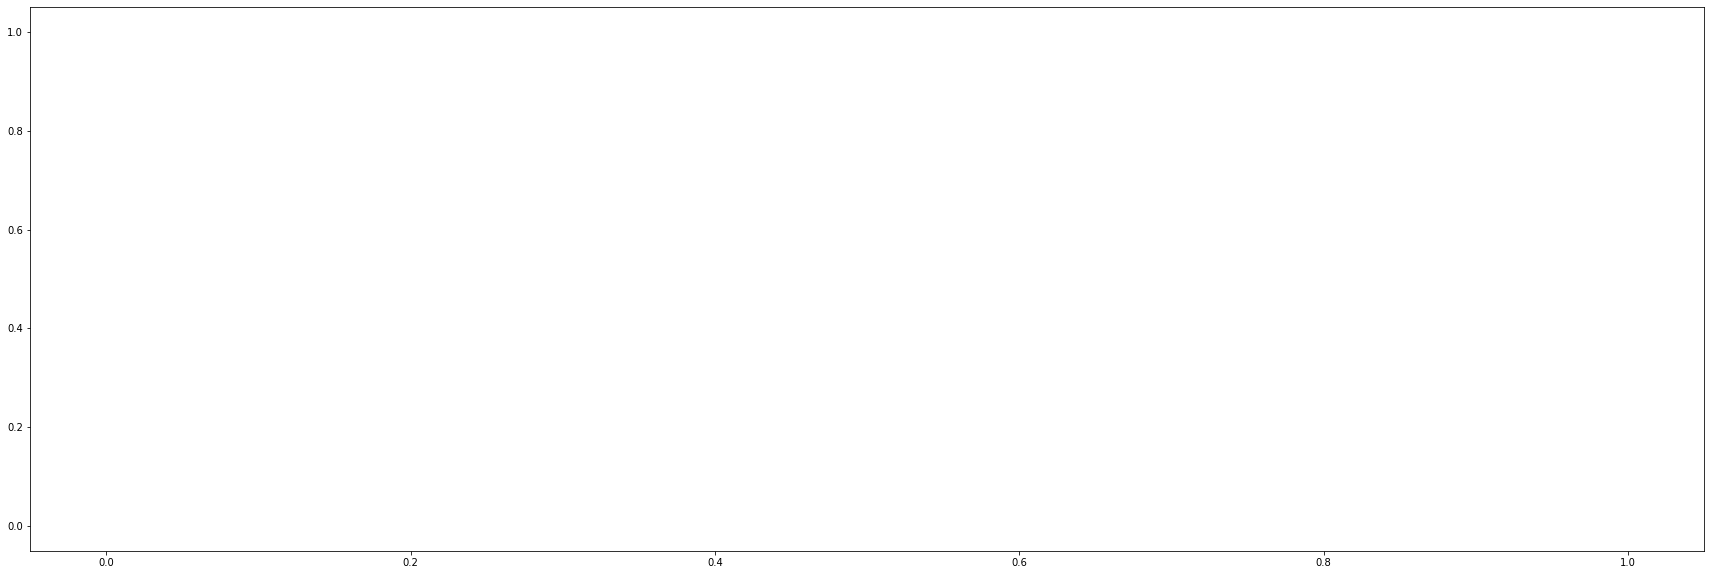

In [11]:
import collections
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

autofreqwords=[x.lower() for y in bbc_df[bbc_df['category']==1]['TASK'] for x in y.split() if x not in stop_words and len(x) > 3]
nonautofreqwords=[x.lower() for y in bbc_df[bbc_df['category']==-1]['TASK'] for x in y.split() if x not in stop_words and len(x) > 3]
automatablecounts = collections.Counter(autofreqwords)
autodict = dict(sorted(automatablecounts.items(),
                           key=lambda item: item[1],
                           reverse=True))
nonautodict = dict(sorted(collections.Counter(nonautofreqwords).items(),
                           key=lambda item: item[1],
                           reverse=True))

# plotting the top 20 frequent words in the automatable inputs
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

data = list(autodict.values())[0:20]
plt.figure(figsize=(30,10))
plt.bar(list(autodict.keys())[0:20], data)
plt.show()

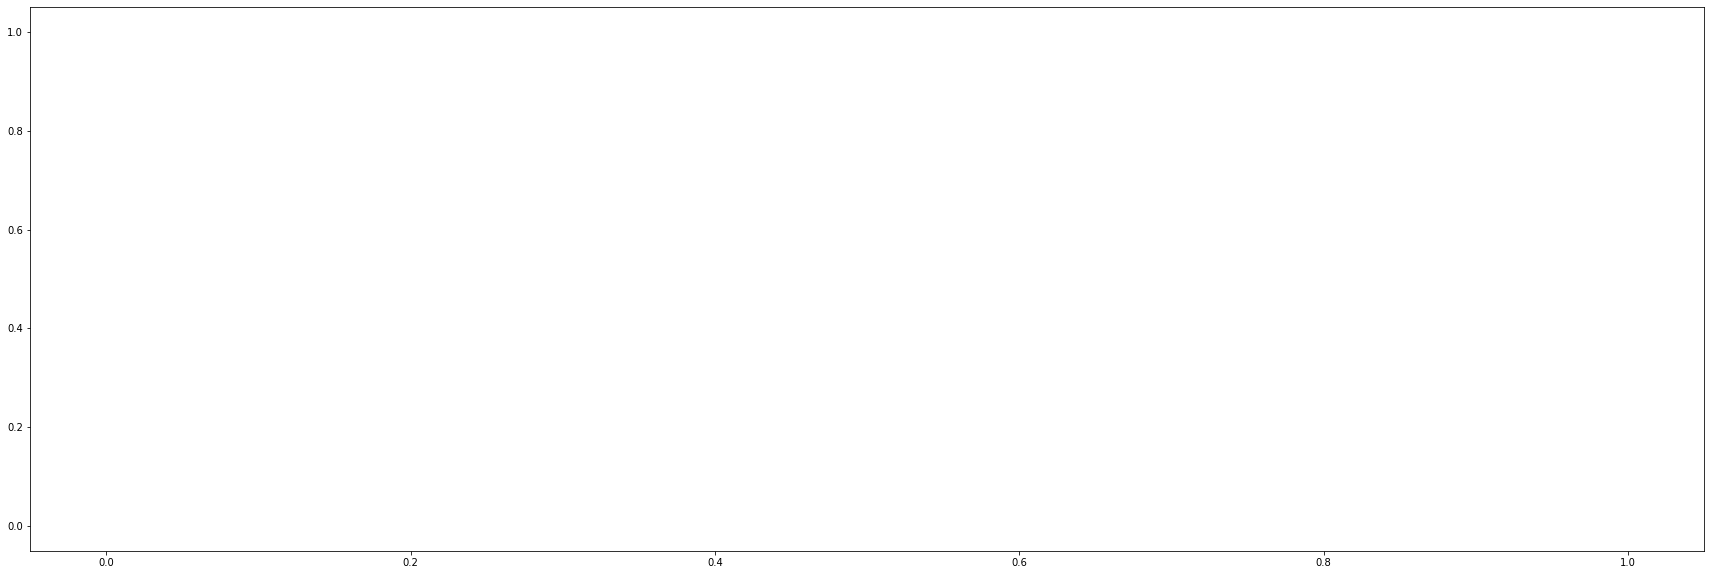

In [15]:
data = list(nonautodict.values())[0:20]
plt.figure(figsize=(30,10))
plt.bar(list(nonautodict.keys())[0:20], data)
plt.show()

## Data preparation

Let's take "sport" category as our traning class for one-class classification

so let's replace the category labels

Since "sport" is our traning class let's replace "sport" with "1" and replace "business, politics, tech and entertainment" with "-1"

becuase one-class classification model prediction will be 1 or -1

here "1" is target class and "-1" is the outlier

In [16]:
# change category labels
bbc_df['category'] = bbc_df['category'].map({'automatable':1,'non-automatable':-1})

In [17]:
# create a new dataset with only sport category data
sports_df = bbc_df[bbc_df['category'] == 1]

In [18]:
sports_df.shape

(14416, 8)

In [19]:
# create train and test data
train_text = sports_df['TASK'].tolist()
train_labels = sports_df['category'].tolist()

test_text = bbc_df['TASK'].tolist()
test_labels = bbc_df['category'].tolist()

## Data Cleaning and Tokenization

In [20]:
import re
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
# stop words list
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
# special characters
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

In [21]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
# class for cleaning the text
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
            return {}

def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

In [22]:
def tokenizeText(sample):
    
    tokens = sample.split()
    
    # lemmatization
    lemmas = []
    for tok in tokens:
        lemmas.append(lemmatizer.lemmatize(tok).strip())
    tokens = lemmas
    
    # remove stop words and special characters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    # only take words with length greater than or equal to 3
    tokens = [tok for tok in tokens if len(tok) >= 3]
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    # stemming of words
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]
    
    return list(set(tokens))

In [23]:
# lets see tokenized random text
tokenizeText(train_text[9])

['util', 'cpu']

## Feature Extraction

In [24]:
# getting features

vectorizer = HashingVectorizer(n_features=20,tokenizer=tokenizeText)

features = vectorizer.fit_transform(train_text).toarray()
features.shape

(14416, 20)

## One-class SVM

One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

In [25]:
from sklearn.calibration import CalibratedClassifierCV
# OneClassSVM algorithm
clf = OneClassSVM(nu=0.1, kernel="linear", gamma=0.01)
#kernel='rbf', nu=outlier_prop, gamma=0.000001
#scv_calibrated = CalibratedClassifierCV(clf)
pipe_clf = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])


In [26]:
# fit OneClassSVM model 
pipe_clf.fit(train_text, train_labels)


Pipeline(memory=None,
         steps=[('cleanText',
                 <__main__.CleanTextTransformer object at 0x000002A392721A90>),
                ('vectorizer',
                 HashingVectorizer(alternate_sign=True, analyzer='word',
                                   binary=False, decode_error='strict',
                                   dtype=<class 'numpy.float64'>,
                                   encoding='utf-8', input='content',
                                   lowercase=True, n_features=20,
                                   ngram_range=(1, 1), norm='l2',
                                   preprocessor=None, stop_words=None,
                                   strip_accents=None,
                                   token_pattern='(?u)\\b\\w\\w+\\b',
                                   tokenizer=<function tokenizeText at 0x000002A38D432378>)),
                ('clf',
                 OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01,
                             ker

In [27]:
# calculate score
# validate OneClassSVM model with train set
from sklearn.metrics import f1_score
preds_train = pipe_clf.predict(train_text)
score = f1_score(train_labels, preds_train, pos_label=1)
print("training data evaluation metrics:")
print("accuracy: %.2f" % accuracy_score(train_labels, preds_train))
print('F1 Score: %.2f' % score)

training data evaluation metrics:
accuracy: 0.53
F1 Score: 0.69


In [28]:
# validate OneClassSVM model with test set
from sklearn.metrics import f1_score
preds_test = pipe_clf.predict(test_text)
score = f1_score(test_labels, preds_test, pos_label=1)
print("test data evaluation metrics:")
print("accuracy: %.2f" % accuracy_score(test_labels, preds_test))
print('F1 Score: %.2f' % score)
results = confusion_matrix(test_labels, preds_test) 
print('Confusion Matrix :')
print(results) 
print('Report : ')
print(classification_report(test_labels, preds_test)) 

test data evaluation metrics:
accuracy: 0.54
F1 Score: 0.66
Confusion Matrix :
[[1527 1028]
 [6809 7607]]
Report : 
              precision    recall  f1-score   support

          -1       0.18      0.60      0.28      2555
           1       0.88      0.53      0.66     14416

    accuracy                           0.54     16971
   macro avg       0.53      0.56      0.47     16971
weighted avg       0.78      0.54      0.60     16971



In [29]:
print(results)

[[1527 1028]
 [6809 7607]]


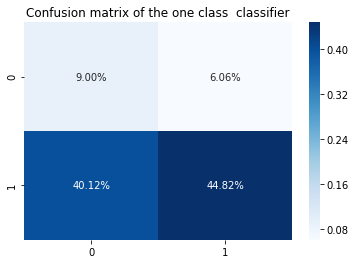

In [30]:
import seaborn as sns
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Confusion matrix of the one class  classifier')
sns.heatmap(confusion_matrix(test_labels, preds_test)/np.sum(confusion_matrix(test_labels, preds_test)) ,annot=True,fmt='.2%', cmap='Blues')
plt.show()

Let's check how model is performing 

In [31]:
#x = test_text
#y= test_labels
#plt.scatter(x,y,alpha=0.7, c=y) 
#plt.xlabel('x1') 
#plt.ylabel('x4')

In [32]:
# let's take random text from dataset
test_text[3]

'Performance report'

In [33]:
# check actual category
test_labels[3]

1

In [57]:
# let's predict the category of above random text
print(pipe_clf.predict([test_text[3]]))
print(pipe_clf.predict(['outlook failed to open because of new patch']))
print(pipe_clf.predict(['laptop steal issue ']))
print(pipe_clf.predict(['laptop not opened because of lockdown']))


[1]
[1]
[-1]
[-1]


In [35]:
'outlook failed to open because of new patch'

'outlook failed to open because of new patch'

our model predicted random text as sport category which is correct

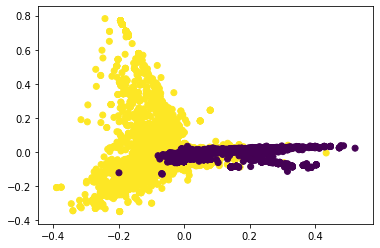

In [36]:
%matplotlib inline
#from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
#https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
#newsgroups_train = fetch_20newsgroups(subset='train', 
                                      #categories=['alt.atheism', 'sci.space'])
#print(newsgroups_train.target)
#print(newsgroups_train)
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(test_text).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=test_labels)
plt.show() 

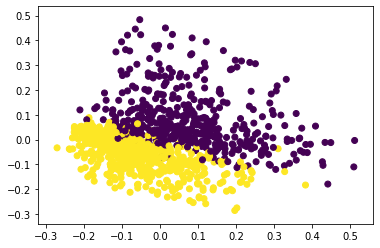

In [37]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

newsgroups_train = fetch_20newsgroups(subset='train', 
                                      categories=['alt.atheism', 'sci.space'])
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(newsgroups_train.data).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=newsgroups_train.target)
plt.show()              #not required if using ipython notebook


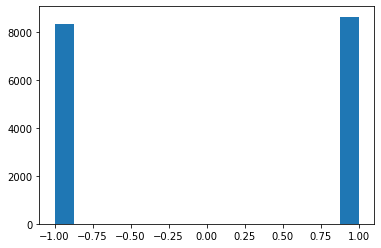

In [38]:
plt.hist(preds_test, bins='auto')
plt.show()

In [39]:
preds_test.shape

(16971,)

In [40]:
for i in range(len(test_labels)):
    if preds_test[i] == -1 and test_labels[i] == 1:
        print(test_text[i])

VM tools updates by ESX update
VM Hardware installation with commands
CPU Utilization
Physical Memory Utilization
Device Temperature
Link Utilization
Device Uptime
fetch report of switchport status on one or multiple switches. [example headings: switchname, switchport interface number, interface status, learning mac address on the interface, interface description,..]
fetch list of accesspoint client details with IP address & hostnmaes
Fetch list of APs associated in WLC with High Availability details
Add/Delete users to/from AD groups
Creating new admins in security appliances
Check the VPN tunnel status in firewall
Manage drive cleanings
Monitoring backup alert failures
Monitor Backup jobs
Provide public folder administration services, including creation/deletion of folders, folder owner permissions and ownership assignment, and folder replication management.
Organizational Unit creation, deletion and delegation.
Backing up / restoring Active Directory objects.
Reviewing all performan

Memory Utlization
Security compliance for all LAN devices
New switch installation
Link/Hardware Utilization Trend Analysis, Newspaper, etc..
IOS Upgrade
Automated NetApp Hardware health status check
Automated NetApp Volume utilization status check
Automated NetApp Aggregare utilization status check
Switch port Link failure report
Database monitoring
Database file growth rate
Agent job status
VMAX Not Logged in Servers
Uptime
 ADM account not used more than 90 days to  be moved to Freezer OU and Managers to be emailed of the same. 
Identify Security groups without owners and generate a report on a monthly basis
Identify Security groups without members and report on a monthly basis with owner details
Alert for New Database Creation
Identify security groups with users in disabled state and remove them out of it
EMC NAS Array file system utilization
Policy Details Extraction (Netbackup)
Scratch Tape Avaliability (CommVault)
New Citrix Environment user counts
Cluster failover monitoring
Cus

Listing Virtual Memory - swapon,free commands
Start/Stop syslogd daemon
Configure a DNS Client
monitor CPU Utilization
monitor Memory Utilization
monitor I/O Utilization
List HBA and their ports
Use multipath devices
start/stop multipath
Monitoring agent (nmon)
Configure hardware failure alert
Creating complex Application Packages in SCCM using advanced tools
Creating SCCM Collection for Deployment with a dynamic conditions
Automated remediation of Domain Trust relationship corruption - With Weekly Reports
Software Inventory for specific SW Items requested by client - Dynamic query
SCCM Client remediation automation - WMI, Low disk space, Access denied etc. 
Report on SCCM infrastructure servers specific network availability
Alert Customization /supression (Warning alert customization)
Configure Database Mail
Configure Temp Database
Create necessary DB user accounts
Create Database backup plan
Create database
Testing backup using tool
Memory utilization for SQL server processes
Shrink 

Integration with Tacacs, Spectrum, NetFlow
Configure DHCP server & scopes
Flexconnect configuration 
CPU Utilization Issue
Memory Utilization Issue
Utilization Issue
Switch Configuration
Server Installation
Windows Services Management
Server reboot upon issue/request
Creating VMï¿½s using Templates
Perfomance issues like CPU and Memory for ESX hosts
Building New VM for Linux OS
Add/Modify/Delete/Display users
Add/Modify/Delete/Display groups
Extend the filesystems with online JFS 
Identify type of network card in VM
Retired Users
Server hardening
Share Utilization
Install/Configure  Virtual Machines
monitor CPU Utilization
monitor Memory Utilization
Disk Utilization
Ping failed
Check Disk I/O utilization in server
Memory
Archiving and cleaning  database logs/trace  files  in a timely fashion(Implementation of Log rotation)
Manage growth rate of  database tables
Monitor and manage Tablespaces
Monitor database backups and perform proactive actions as required
Management - DHCP Scope (Reg

Tablespace  - monitors tablespace using the predefined db query
Listener -(monitors listner for 3 predefined parameters)
Monitor  (3 predefined parameters)
Configure Database Mail
Configure Temp Database
Create Database backup plan
Create DB maintenance plans
Create directory structure layout to place database files
Create database
Perform database upgrade
Create Audit
Enabling/Disabling audits
Database monitoring
CPU usage
Memory usage
Database file growth rate
Transaction log file growth rate
Agent job status
Manage performance metrics (create/modify thresholds)
Capturing performance parameters
Memory utilization for SQL server processes
Performance parameters using diagnostic tools (e.g. PAL)
Instance/OS/Database configuration parameters
Add Job steps
Monitor Clustering
Rebuild Index
Reorganize Index
Monitor Fragmentation
Create Fulltext Indexes
Citrix Server Load evaluation
Extract the CPU memory utilization
 List all SCCM clients which were restarted in the past 48 hours.
Provisio

Monitoring swap alert in system log file
Managing Crash Dump size - using kdump, crash utility.
Adding User to Security Group
Adding User to Distribution Group
Updating general attribute of user
Renaming SMTP Address
Mail forwading
Creation of security / Distribution Group
Providing O365 license to mailbox
Providing member list from DL/ Security group
Adding Servers in Maintenance Mode
Daily Activities
Script to monitor the virtual memory status and writes the same into a log file for future reference.
Weekly report generation
Working with Communication Error
Access Control Validation - Remove Unnecessary Users from Security Group
Service failures
Server Build 
Server build audit
Robot Inactive 
Ping failure 
Server Performance report
Installing the softwareâs for group of servers
Print Server Management ( Port/Print Instances)
Citrix Farm Uptime/Restart Frequency
 server-side profiler trace is created and maintained by a job on the instance to be monitored (
monitoring licence capac

Orpahn User
DB Growth
Alert for new database creation
Performance Troubleshooting
The script is used to create audit for all databases in every instance of SQL using powershell.
MONITOR SQL SERVER HEALTH FOR MULTIPLE INSTANCES AND TRIGGER ALERT MAIL
Gathering FPOS Logs
Configure Outlook
Default Homepage Setup
Checkpoint VPN
Providing Grants to users and roles
Assign profile to database users. 
Adding a new resources (Eg: filesystem ) into existing Cluster
Incident Audit Automation
All clients backup / duplicate / restore failures from last 24 hours
Check that all the clients which are configured in backup rotation are Getting jobs triggered everyday without fail make sure we are not Missing any day backup
Client installation/remotely/based on platform
Disaster recovery ofï¿½ Client (windows,unix,linux, etc.)
Make sure that all the clients whose job got failed are having incident
Manage backup failure (due to missed files or missed backups) and analyze logs and run make up jobs
The Abov

Incident Management Report
NIDB Command
SET DAY Command
UNIX COMMAND
Price Protection
File Transfer Protocol (FTP) request
Install a printer
New Outlook Profile Setup
Update the AV policy and keep the computer up to date
Outlook profile default location D: Drive
1099 Pro Installation
1042-S Installation
Smartview configuration in Excel
AS400 Installation and Configuration
New Machine Installation and Configuration in Domain
Celerra Cifs configuration
Uploading Switch configuration
Invalid Index rebuild from OEM using metrics rectification
control_management_pack_access Check on all Oracle Databases
GCDMPR and Superhub difference
Pointer and full snapshot backup
Monitoring and failover with Primary Internet link of Wireless P2P link terminating on Firewall
WAN link utilization report
Firewall reporting using Panorama
Auto Notification - P1 and P2 through web portal
Auto Alert Suppression before maintenace
Report automation for alert trend
Generating reports for mails which queued in Hur

Monitor folder permission
VIP RU Count
Trend Micro OfficeScan XG Agent Silent Installation.
RAS Report Automation
auto ticket creation in AT&T when router is down
Adding users into a Group

Check Patch/packages

Check status/Monitoring/quorate state - (3 predefined parameters )

Check the File System status - stat command

Cluster Config Validation
Cluster Configuration update

Cluster Failback

Database file growth rate

Extract the CPU memory utilization

Install Oracle Software using the existing script

Monitor Log shipping 

Start/Stop syslogd daemon

Transaction log file growth rate

ReadFile

PMO Portal
Adding Users to Search Group
STCOM
Device Count
SNOW Reconciliation report
Auto Generation of Problem Tickets
Auto Creation Of Incidents For Alerts
Troubleshooting of Backup client
CPU Monitoring
Memory Monitoring
ISE Profile creation
Link down alert
Device Count
Automatic Database Refresh
Display Computer Status in GUI(IP-Address check,Pingable or Not, Uptime, OS, OS_Version, La

In [41]:
features.shape

(14416, 20)

In [42]:
print(features[0])

[-0.57735027  0.          0.          0.          0.          0.57735027
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.57735027  0.        ]


In [43]:
features1 = vectorizer.fit_transform(["cat"]).toarray()

In [44]:
features


array([[-0.57735027,  0.        ,  0.        , ...,  0.        ,
        -0.57735027,  0.        ],
       [ 0.        ,  0.        ,  0.70710678, ...,  0.        ,
         0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.4472136 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.57735027, ...,  0.        ,
         0.        ,  0.        ]])

In [45]:
from eli5.sklearn import InvertableHashingVectorizer
import numpy as np
ivec = InvertableHashingVectorizer(vectorizer)
sample_size = len(test_text) // 10
X_sample = np.random.choice(test_text, size=sample_size)
ivec.fit(X_sample)

InvertableHashingVectorizer(unkn_template='FEATURE[%d]',
                            vec=HashingVectorizer(alternate_sign=True,
                                                  analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, n_features=20,
                                                  ngram_range=(1, 1), norm='l2',
                                                  preprocessor=None,
                                                  stop_words=None,
                                                  strip_accents=None,
                                                  token_pattern='(?u)\\b\\w\\w+\\b',
                                                 

In [46]:
import eli5

In [47]:
eli5.show_weights(clf, vec=ivec, top=20,target_names=['automatable','non-automatable'])

In [48]:
import pickle

In [51]:
from sklearn.externals import joblib 

c:\users\ranjith_n\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [52]:
pipe_clf

Pipeline(memory=None,
         steps=[('cleanText',
                 <__main__.CleanTextTransformer object at 0x000002A392721A90>),
                ('vectorizer',
                 HashingVectorizer(alternate_sign=True, analyzer='word',
                                   binary=False, decode_error='strict',
                                   dtype=<class 'numpy.float64'>,
                                   encoding='utf-8', input='content',
                                   lowercase=True, n_features=20,
                                   ngram_range=(1, 1), norm='l2',
                                   preprocessor=None, stop_words=None,
                                   strip_accents=None,
                                   token_pattern='(?u)\\b\\w\\w+\\b',
                                   tokenizer=<function tokenizeText at 0x000002A38D432378>)),
                ('clf',
                 OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01,
                             ker

In [54]:
joblib.dump(pipe_clf, 'ideation.pkl') 

['ideation.pkl']

In [55]:
knn_from_joblib = joblib.load('ideation.pkl') 

In [58]:
knn_from_joblib.predict(['outlook failed to open because of new patch'])

array([1], dtype=int64)